# Modelling and Evaluation

## Objectives

- Answer business objective 2:
    - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

- inputs/malaria_dataset/cell_images/train
- inputs/malaria_dataset/cell_images/test
- inputs/malaria_dataset/cell_images/validation
- image shape pickle file

## Outputs

- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file

## Additional Comments

- None

---

# Get directories
## Change working directory

In [1]:
import os

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")
current_dir = os.getcwd()
current_dir

You set a new current directory


'/workspaces/powdery_mildew_detection'

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set input directories
Set train, test, and validation paths

In [3]:
my_data_dir = 'inputs/mildew_detection/cherry_leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [48]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [5]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

In [6]:
## Import saved image shape pickle file
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Image Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

In [8]:
batch_size = 20 # Set batch size

train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

train_set.class_indices

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented images

Train set
(20, 256, 256, 3)


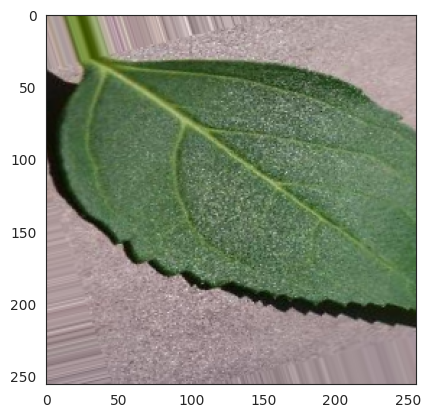

(20, 256, 256, 3)


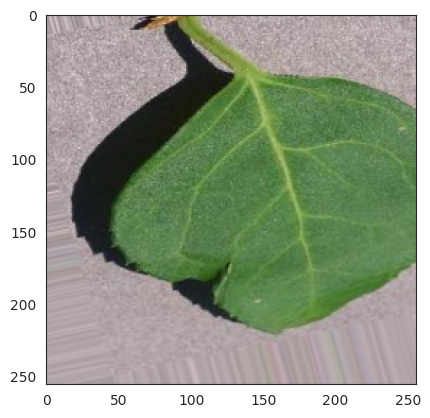

(20, 256, 256, 3)


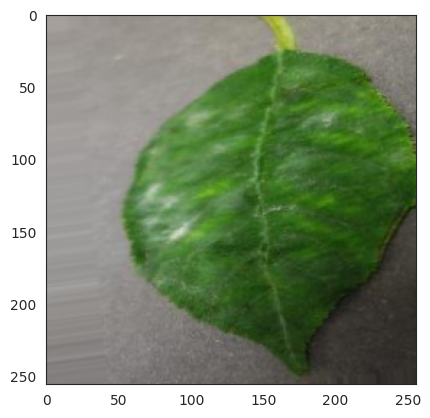

[[[[0.64705884 0.627451   0.6117647 ]
   [0.64705884 0.627451   0.6117647 ]
   [0.64705884 0.627451   0.6117647 ]
   ...
   [0.5646931  0.5490068  0.50586957]
   [0.55861765 0.5429314  0.49979413]
   [0.5497678  0.5340815  0.4909443 ]]

  [[0.64705884 0.627451   0.6117647 ]
   [0.64705884 0.627451   0.6117647 ]
   [0.64705884 0.627451   0.6117647 ]
   ...
   [0.5650562  0.54936993 0.5062327 ]
   [0.5569017  0.5412154  0.4980781 ]
   [0.55077887 0.5350926  0.4919554 ]]

  [[0.64705884 0.627451   0.6117647 ]
   [0.64705884 0.627451   0.6117647 ]
   [0.64705884 0.627451   0.6117647 ]
   ...
   [0.5567727  0.54108644 0.49794918]
   [0.5548822  0.53919595 0.49605873]
   [0.55470103 0.53901476 0.49587753]]

  ...

  [[0.52156866 0.5058824  0.5019608 ]
   [0.52156866 0.5058824  0.5019608 ]
   [0.52156866 0.5058824  0.5019608 ]
   ...
   [0.20121369 0.18944898 0.16984114]
   [0.19308452 0.18131982 0.16171196]
   [0.18855612 0.17679141 0.15718356]]

  [[0.5210805  0.5053942  0.50147265]
   [0.5

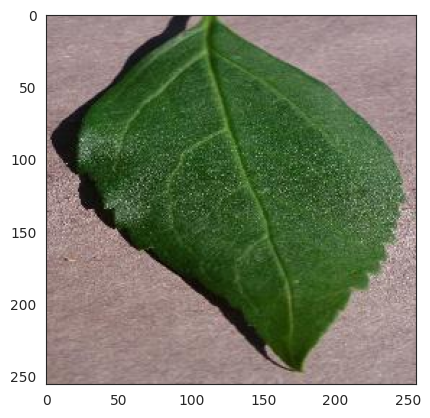

(20, 256, 256, 3)


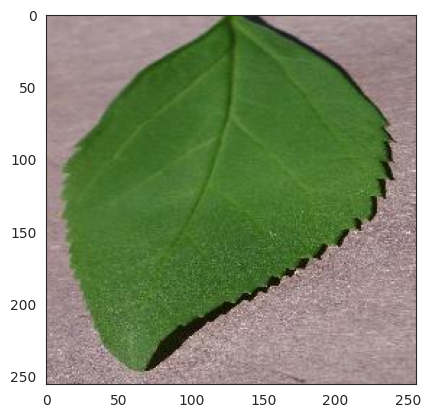

(20, 256, 256, 3)


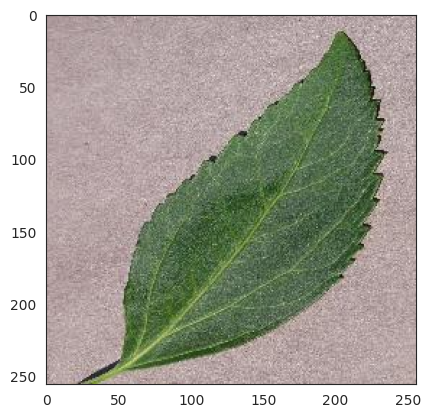

Test set
(20, 256, 256, 3)


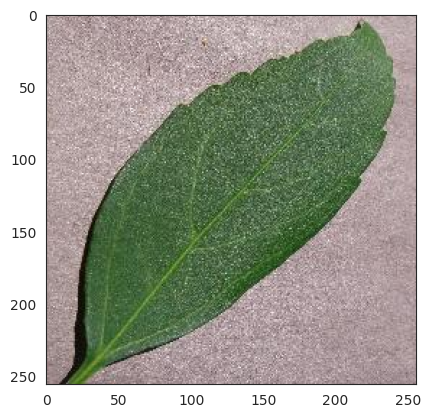

(20, 256, 256, 3)


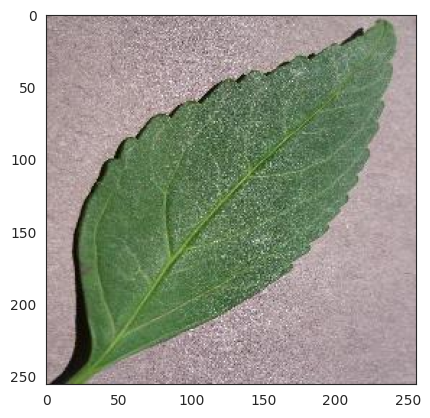

(20, 256, 256, 3)


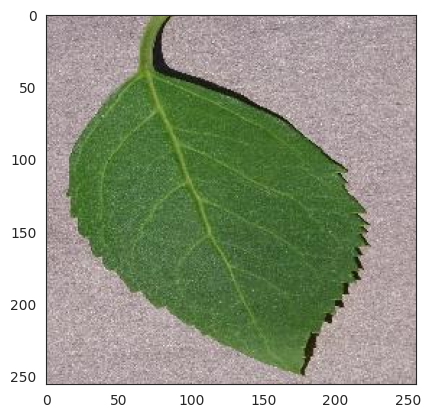

In [20]:
print("Train set")
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

print("Validation set")
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()
    
print("Test set")
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [49]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

# Model Creation

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

## Model

In [45]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

### Model Summary

In [46]:
create_tf_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 57600)            

### Early Stopping

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Fit model for Model Training

In [ ]:
model = create_tf_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/10
147/147 [==============================] - 596s 4s/step - loss: 0.3124 - accuracy: 0.8533 - val_loss: 0.0347 - val_accuracy: 0.9905
Epoch 2/10
147/147 [==============================] - 634s 4s/step - loss: 0.1056 - accuracy: 0.9641 - val_loss: 0.0351 - val_accuracy: 0.9929
Epoch 3/10
 57/147 [==========>...................] - ETA: 6:25 - loss: 0.0616 - accuracy: 0.9886

## Save Model

In [37]:
model.save(f"{file_path}/powdery_mildew_detector_model.h5")

# Model Performance
## Performance Curve

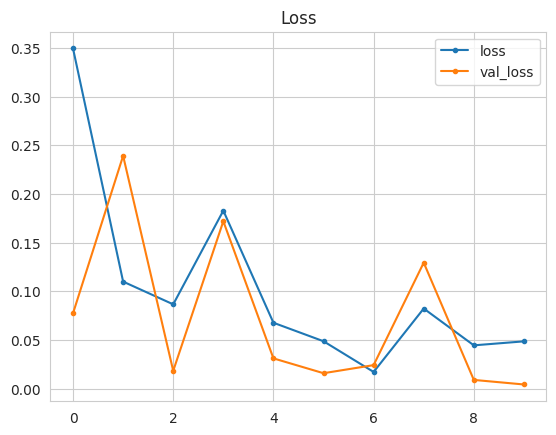

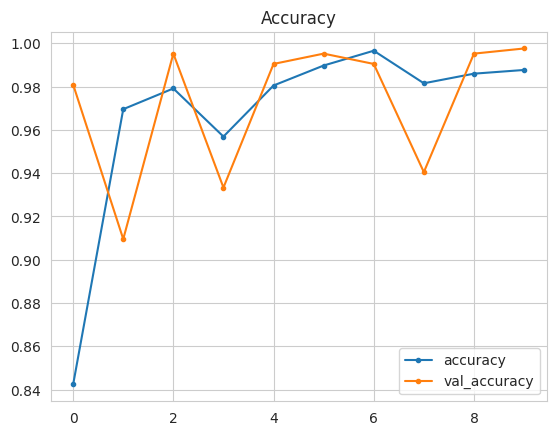

In [38]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [39]:
from keras.models import load_model
model = load_model(f"{file_path}/powdery_mildew_detector_model.h5")
evaluation = model.evaluate(test_set)

43/43 [==============================] - 33s 761ms/step - loss: 0.0073 - accuracy: 0.9976


Save evaluation pickle

In [40]:
joblib.dump(value=evaluation ,filename=f"{file_path}/evaluation.pkl")

['outputs/v2/evaluation.pkl']

## Live Prediction
Load random image as PIL and convert image to array

['powdery_mildew', 'healthy']
Image shape: (256, 256), Image mode: RGB


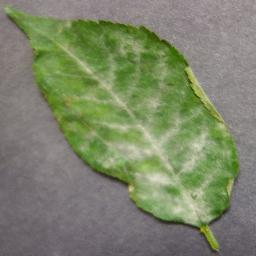

In [41]:
from tensorflow.keras.preprocessing import image

pointer = 126
label = labels[0] # select healthy [1] or powdery mildew [0]
labels = os.listdir(test_path)
print(labels)

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [42]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)
print(my_image.shape)

(1, 256, 256, 3)


Predict healthy or powdery mildew

In [43]:
pred = model.predict(my_image)
pred_class = np.argmax(pred, axis=-1)

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_class[0]]
print(pred_class)


powdery_mildew


# Push files to repo
Push new files to repo to save the models and evaluations

In [48]:
!git add .

In [ ]:
!git commit -m "Add model v3 results, save model"

In [ ]:
!git push